# Bandit Algorithms

Implementation of the basic multi-armed bandit algorithms of Sutton's Reinforcement Learning textbook. 

In [17]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

In [211]:
def softmax(x):
    """ A stable softmax function
    """
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [212]:
class KArmedBandit:
    def __init__(self, k, noise=None, ucb_c=2):
        self.k = k
        self.ucb_c = ucb_c
        self.mu = np.arange(k)
        if noise is None:
            self.std = np.random.chisquare(1, k)
        else:
            self.std = noise * np.ones(k)
        self.q = np.zeros(k)
        self.n = np.zeros(k)
        self.h = np.ones(k)

    def restart(self):
        self.q = np.zeros(k)
        self.n = np.zeros(k)
        self.h = np.ones(k)
    
    def get_reward(self, arm, n=1):
        tmp = np.random.randn() if n==1 else np.random.randn(n)
        return self.std[arm] * tmp + self.mu[arm]

    def argmax_Q(self):
        """ Greedy selection
        """
        q_max = np.max(self.q)
        return np.random.choice(np.where(self.q == q_max)[0])

    def ucb_argmax_q(self, step):
        """ UCB action selection
        """
        ucb = self.q + self.ucb_c * np.sqrt(np.log(step + 1)/(self.n + 1e-6))
        ucb_max = np.max(ucb)
        return np.random.choice(np.where(ucb == ucb_max)[0])

    def gibbs_action(self):
        """ Preference selection for the gradient bandit
        """
        p = softmax(self.h)
        return np.random.choice(np.arange(self.k), p=p), p

    def train_ucb(self, steps):
        """ Section 2.7 of Sutton
        """
        rewards = np.zeros(steps)
        for j in range(steps):
            a = self.ucb_argmax_q(j)
            r = self.get_reward(a)
            rewards[j] = r
            self.n[a] += 1
            self.q[a] += 1 / self.n[a] * (r - self.q[a])
        return rewards

    def train_eps_greedy(self, eps, steps):
        """ Section 2.6 of Sutton
        """
        rewards = np.zeros(steps)
        for j in range(steps):
            if np.random.rand() <= eps:
                a = np.random.choice(self.k)
            else:
                a = self.argmax_Q()
            r = self.get_reward(a)
            rewards[j] = r
            self.n[a] += 1
            self.q[a] += 1 / self.n[a] * (r - self.q[a])
        return rewards

    def train_gradient_bandit(self, alpha, steps):
        """ Section 2.8 of Sutton
        """
        rewards = np.zeros(steps)
        for j in range(steps):
            a, p = self.gibbs_action()
            r = self.get_reward(a)
            rewards[j] = r
            if j > 0:
                dr = alpha * (r - np.mean(rewards[:j]))
            else:
                dr = alpha * r
            self.h -= dr * p
            self.h[a] += dr 
            
        return rewards

In [213]:
k = 10
bandit = KArmedBandit(k)

## Reward Distribution

Let's sample these arms and see what the distribution of rewards looks like for each.

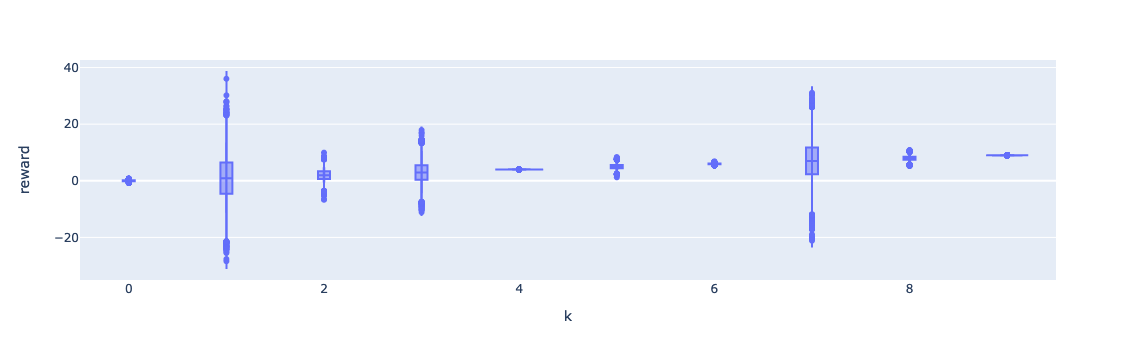

In [214]:
n=10000
rewards = []
arms = []
for arm in range(k):
    arms.extend(arm * np.ones(n))
    rewards.extend(bandit.get_reward(arm, n=n))
df = pd.DataFrame({'k': np.array(arms, dtype=int), 'reward': rewards})
df['k'] = df['k'].astype('category')

px.violin(data_frame=df, x='k', y='reward', box=True)

Compare results across 2000 runs over 1000 steps.

In [215]:
runs = 2000
n = 1000

In [216]:
rewards = {}
for eps in [0.2, 0.1, 0.01, 0]:
    rewards[eps] = np.zeros((runs, n))
    for i in range(runs):
        bandit.restart()
        rewards[eps][i] = bandit.train_eps_greedy(eps, n)

In [217]:
rewards_ucb = np.zeros((runs, n))
for i in range(runs):
    bandit.restart()
    rewards_ucb[i] = bandit.train_ucb(n)

In [218]:
rewards_h = {}
for alpha in [0.4, 0.1, 0.05]:
    rewards_h[alpha] = np.zeros((runs, n))
    for i in range(runs):
        bandit.restart()
        rewards_h[alpha][i] = bandit.train_gradient_bandit(alpha, n)

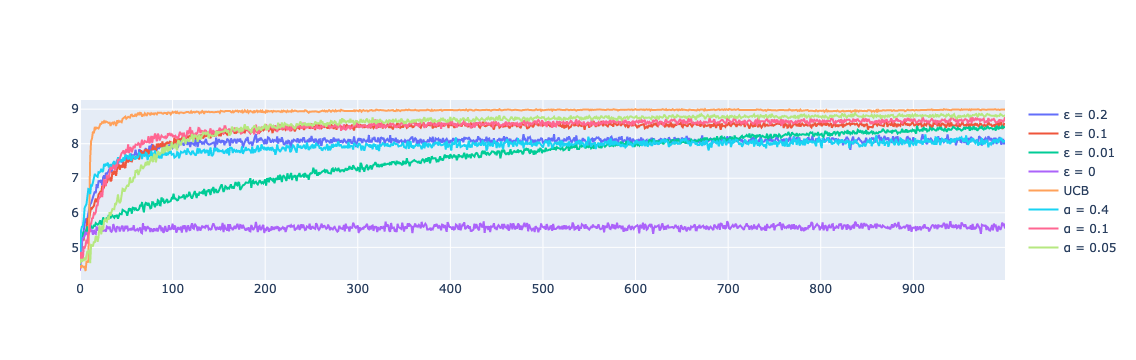

In [220]:
px.line(x=np.arange(n), y=np.mean(rewards_ucb, axis=0))
fig = go.Figure(data= [
    go.Scatter(x=np.arange(n), y=np.mean(rewards[0.2], axis=0), name='ε = 0.2'),
    go.Scatter(x=np.arange(n), y=np.mean(rewards[0.1], axis=0), name='ε = 0.1'),
    go.Scatter(x=np.arange(n), y=np.mean(rewards[0.01], axis=0), name='ε = 0.01'),
    go.Scatter(x=np.arange(n), y=np.mean(rewards[0], axis=0), name='ε = 0'),
    go.Scatter(x=np.arange(n), y=np.mean(rewards_ucb, axis=0), name='UCB'),
    go.Scatter(x=np.arange(n), y=np.mean(rewards_h[0.4], axis=0), name='α = 0.4'),
    go.Scatter(x=np.arange(n), y=np.mean(rewards_h[0.1], axis=0), name='α = 0.1'),
    go.Scatter(x=np.arange(n), y=np.mean(rewards_h[0.05], axis=0), name='α = 0.05'),
]).show()

UCB wins!